%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib
(180, 180, 3)
(1, 180, 180, 3)
0
The image belongs to Organic waste category, probability: 1.0.


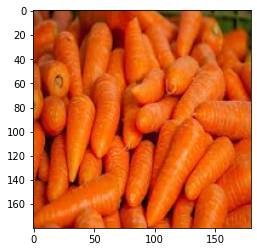

In [118]:
%pylab inline
import numpy as np

In [ ]:
from PIL import Image
from os import listdir
from os.path import isfile, join

def list_files_in(directory):
    return [f for f in listdir(directory) if isfile(join(directory, f))]

def normalize_pic(image_path):
    image = Image.open(image_path)
    image = image.resize((64, 64), Image.ANTIALIAS)
    image = np.array(image)
    if image.shape != (64, 64, 3):
        return None
    return image


In [241]:
import Augmentor
p = Augmentor.Pipeline("augmented_dataset/plastic_processed")
p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
p.zoom(probability=0.3, min_factor=1.1, max_factor=1.6)
p.random_contrast(probability=0.2, min_factor=0.3, max_factor=0.7)
p.random_brightness(probability=0.2, min_factor=0.2, max_factor=1)
p.random_color(probability=0.2, min_factor=0.3, max_factor=0.7)
p.crop_random(probability=0.2, percentage_area=0.7)
p.skew_tilt(probability=0.3)
p.sample(8000)

Initialised with 2125 image(s) found.
Output directory set to augmented_dataset/plastic_processed\output.

Processing <PIL.Image.Image image mode=RGB size=120x74 at 0x1DAFBDF0DC0>:  59%|█████▉    | 4739/8000 [00:10<00:01, 1912.49 Samples/s]                   IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [272]:
from random import shuffle

dataset_X = []
dataset_Y = []

glass = list_files_in('augmented_dataset/glass')
metal = list_files_in('augmented_dataset/metal')
paper = list_files_in('augmented_dataset/paper')
plastic = list_files_in('augmented_dataset/plastic')

def generate_label_for(data, label):
    return [label for i in range(data)]

def prepare_data(dataset_path, category, category_name):
    data = []
    for path in category:
        prepared_image_or_none = normalize_pic(f'{dataset_path}/{category_name}/{path}')
        if prepared_image_or_none is not None :
            data += [prepared_image_or_none]
    return data

data = prepare_data('augmented_dataset', glass, 'glass')
size = len(data)
dataset_X += data
dataset_Y += generate_label_for(size, [1, 0, 0, 0])

data = prepare_data('augmented_dataset', metal, 'metal')
size = len(data)
dataset_X += data
dataset_Y += generate_label_for(size, [0, 1, 0, 0])

data = prepare_data('augmented_dataset', paper, 'paper')
size = len(data)
dataset_X += data
dataset_Y += generate_label_for(size, [0, 0, 1, 0])


data = prepare_data('augmented_dataset', plastic, 'plastic')
size = len(data)
dataset_X += data
dataset_Y += generate_label_for(size, [0, 0, 0, 1])

def shuffle_dataset(x, y):
    c = list(zip(x, y))
    shuffle(c)
    a, b = zip(*c)
    return np.array(a), np.array(b)


dataset_X, dataset_Y = shuffle_dataset(dataset_X, dataset_Y)
dataset_X = dataset_X / 255

print(dataset_X.shape, dataset_Y.shape)

(31887, 64, 64, 3) (31887, 4)


In [284]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from keras.optimizer_v2.adam import Adam
from keras.callbacks import  EarlyStopping


model = Sequential()

model.add(Conv2D(80, kernel_size=(3, 3), kernel_initializer='he_uniform', padding='same', activation='relu', input_shape=(64, 64, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(120, kernel_size=(3, 3), kernel_initializer='he_uniform', activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))

model.add(Conv2D(200, kernel_size=(3, 3), kernel_initializer='he_uniform', activation='relu'))
model.add(Conv2D(200, kernel_size=(3, 3), kernel_initializer='he_uniform', activation='relu'))
model.add(Conv2D(120, kernel_size=(3, 3), kernel_initializer='he_uniform', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(250, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(4, activation='softmax'))


model.summary()

model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(lr=1.0e-4),
    metrics=['categorical_accuracy', 'accuracy']
)


Model: "sequential_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_238 (Conv2D)          (None, 64, 64, 80)        2240      
_________________________________________________________________
max_pooling2d_46 (MaxPooling (None, 32, 32, 80)        0         
_________________________________________________________________
conv2d_239 (Conv2D)          (None, 30, 30, 120)       86520     
_________________________________________________________________
max_pooling2d_47 (MaxPooling (None, 10, 10, 120)       0         
_________________________________________________________________
dropout_165 (Dropout)        (None, 10, 10, 120)       0         
_________________________________________________________________
conv2d_240 (Conv2D)          (None, 8, 8, 200)         216200    
_________________________________________________________________
conv2d_241 (Conv2D)          (None, 6, 6, 200)       

C:\Users\Vladimir\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [285]:
from keras.callbacks import TensorBoard

model_code = '15'

early_stopping_callback = EarlyStopping(monitor='loss', patience=4, min_delta=0.01)
tensorboard_callback = TensorBoard(log_dir=f'./logs{model_code}')

filepath = 'model.epoch{epoch:02d}-loss{val_loss:.2f}.hdf5'

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    verbose=1,
    mode='max',
    save_best_only=True
)

model.fit(
    x=dataset_X,
    y=dataset_Y,
    shuffle=False,
    validation_split=0.2,
    batch_size=150,
    epochs=80,
    callbacks=[early_stopping_callback, tensorboard_callback, model_checkpoint_callback],
)
model.save(f'model{model_code}.h5')

Epoch 1/80
171/171 [==============================] - 128s 743ms/step - loss: 1.4250 - categorical_accuracy: 0.2625 - accuracy: 0.2625 - val_loss: 1.3703 - val_categorical_accuracy: 0.3115 - val_accuracy: 0.3115